In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import preprocessing, model_selection
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

import mytrain_lib as ml

import importlib

torch.manual_seed(0)
import random
random.seed(0)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
path_train      = 'F://TFG//datasets//data_train//'
path_graphs     = 'F://TFG//graphs//plot_results//'
path_results    = 'F://TFG//results//'

In [4]:
data = pd.read_csv(path_train+'training_features_DF.csv',sep=';',index_col='wyId')
raw_Data = pd.read_json('F://TFG//datasets/raw_datasets//RAW_partidos.json').set_index('wyId')

In [5]:
data.head(5)

,mins4_H,mins4_A,shots_11H,shots_11A,shots_acc_11H,shots_acc_11A,goals_H,goals_A,goals_ratio_H,goals_ratio_A,...,passes_acc_11H,passes_acc_11A,keyPasses_H,keyPasses_A,ataque_h,defensa_h,ataque_a,defensa_a,ataquedefensa_H,ataquedefensa_A
wyId,,,,,,,,,,,,,,,,,,,,,
2499738,60.818182,56.840909,28,18,0.321429,0.444444,1,3,0.250000,0.500000,...,0.757778,0.782137,5,6,0.76,1.72,0.96,2.24,0.973546,0.817933
2499799,54.500000,72.454545,35,28,0.400000,0.321429,4,5,1.000000,0.625000,...,0.851005,0.843464,4,8,0.56,0.84,2.00,1.20,1.316667,0.810784
2499800,63.295455,72.000000,37,29,0.162162,0.344828,1,1,0.333333,1.000000,...,0.836437,0.858100,16,7,0.60,1.20,0.48,1.72,0.983333,1.399187
2499801,42.000000,54.272727,28,22,0.392857,0.409091,2,4,1.000000,0.571429,...,0.785348,0.842152,8,3,0.36,2.16,1.04,0.32,0.689456,1.360256
2499802,63.659091,51.477273,47,25,0.510638,0.480000,10,4,0.555556,0.666667,...,0.904959,0.763764,15,2,5.48,1.08,1.24,0.64,1.935507,0.921212


In [6]:
train_data  = ml.FootballMatchesDataset(file = 'train')
test_data   = ml.FootballMatchesDataset(file = 'test')

len(train_data), len(test_data)

(1100, 314)

In [7]:
dataloader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)
train_feat, train_lab, m = next(iter(dataloader))
train_lab, m

(tensor([[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.]]),
 tensor([2576098, 2516836, 2501053, 2576160]))

In [8]:
data.loc[m]

,mins4_H,mins4_A,shots_11H,shots_11A,shots_acc_11H,shots_acc_11A,goals_H,goals_A,goals_ratio_H,goals_ratio_A,...,passes_acc_11H,passes_acc_11A,keyPasses_H,keyPasses_A,ataque_h,defensa_h,ataque_a,defensa_a,ataquedefensa_H,ataquedefensa_A
wyId,,,,,,,,,,,,,,,,,,,,,
2576098,42.000000,59.500000,27,54,0.333333,0.388889,3,4,0.375000,0.571429,...,0.825308,0.889425,5,10,1.28,1.68,1.24,0.72,0.912630,1.486054
2516836,36.659091,69.681818,12,18,0.166667,0.277778,0,1,0.000000,0.500000,...,0.721044,0.838248,1,5,0.00,1.20,0.36,1.64,0.775641,1.094678
2501053,38.500000,59.636364,51,22,0.333333,0.318182,4,1,0.800000,0.500000,...,0.879603,0.798144,11,5,1.12,0.68,0.72,2.52,1.088674,0.645833
2576160,68.681818,54.500000,51,21,0.352941,0.285714,6,1,0.666667,1.000000,...,0.823607,0.820858,11,3,2.68,0.88,0.12,1.64,1.517949,0.709860


In [9]:
scaler  = preprocessing.StandardScaler()
train_data.data = scaler.fit_transform(train_data.data)

# Neural Network Implementation

Define the class:

## I) Artificial Neural Network Approach to Football Score Prediction

Multilayer Perceptron with 1 hidden layer with BacpPropagation.
6 units input -> 5 hidden units -> 2 output units w/ sigmoid

Data Normalized [0,1]

In [10]:
train_data  = ml.FootballMatchesDataset(file = 'train')
test_data   = ml.FootballMatchesDataset(file = 'test')

In [11]:
normalizer = preprocessing.Normalizer()
train_data.data = normalizer.fit_transform(train_data.data)

In [17]:
print(train_data.data.mean(), train_data.data.std())
print(train_data.data.max(),  train_data.data.min())

0.06813519 0.20202015
0.96471554 0.0


In [18]:
dataloader_train    = DataLoader(train_data, batch_size=32, shuffle=True)
dataloader_test     = DataLoader(test_data,  batch_size=32, shuffle=True)

train_feat, train_lab, m = next(iter(dataloader_train))
train_feat[:3],train_lab[:3] ,m[:3]

(tensor([[3.8423e-02, 2.9142e-02, 2.8814e-02, 1.1082e-02, 2.6640e-04, 2.2165e-04,
          4.4330e-03, 1.6624e-03, 4.0300e-04, 5.5412e-04, 8.3949e-01, 5.4027e-01,
          4.6926e-04, 4.7228e-04, 6.6494e-03, 3.3247e-03, 2.0835e-03, 8.8659e-04,
          3.5464e-04, 1.1747e-03, 8.4113e-04, 4.2620e-04],
         [3.8170e-02, 3.0055e-02, 3.4136e-02, 1.5703e-02, 3.5502e-04, 2.6715e-04,
          8.1927e-03, 2.7309e-03, 6.8272e-04, 5.4618e-04, 9.1553e-01, 3.9734e-01,
          5.5443e-04, 5.2788e-04, 7.5100e-03, 2.0482e-03, 2.2393e-03, 1.0650e-03,
          1.0104e-03, 1.1470e-03, 1.2018e-03, 6.0395e-04],
         [2.6653e-02, 3.1132e-02, 1.1824e-02, 1.6203e-02, 2.7573e-04, 1.7753e-04,
          3.0654e-03, 1.7517e-03, 4.3792e-04, 2.9195e-04, 5.2900e-01, 8.4737e-01,
          3.6505e-04, 3.7704e-04, 2.1896e-03, 3.9413e-03, 1.0510e-03, 4.9047e-04,
          5.7805e-04, 1.9268e-04, 4.9974e-04, 6.2332e-04]]),
 tensor([[0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.]]),
 tensor([257

In [30]:
raw_Data.loc[[2576042, 2500003, 2576265]].label

wyId
2576042                Lazio - Cagliari, 3 - 0
2500003    Liverpool - Newcastle United, 2 - 0
2576265         Torino - Internazionale, 1 - 0
Name: label, dtype: object

In [107]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_feature, ouput_classes):
        super().__init__()
        
        self.h1 = nn.Linear(in_features=input_feature,out_features=5)
        self.bn = nn.BatchNorm1d(5)
        self.out = nn.Linear(5,ouput_classes)

    def forward(self,x):
        # x = F.relu(self.h1(x))
        x = self.h1(x)
        x = F.relu(self.bn(x))
        # return self.out(x)    
        return F.softmax(self.out(x),1)    

    def reset_weights(self):
        self.h1.reset_parameters()
        self.bn.reset_parameters()
        self.out.reset_parameters()    

In [74]:
model = NeuralNetwork(22,3)

In [75]:
# Print out the architecture and number of parameters.
print(model)
print(f"The model has {sum([x.nelement() for x in model.parameters()]):,} parameters.")

NeuralNetwork(
  (h1): Linear(in_features=22, out_features=5, bias=True)
  (bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 143 parameters.


##### Loss Function: Cross-entropy Loss

we can provide `weights`, as prior probability of each class $C$.

In [93]:
train_data.labels   # in 1-hot encoding

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [94]:
# weights_class = np.mean(train_data.labels.numpy(),axis=0)

criterion = nn.BCELoss()

In [95]:
input = torch.tensor([[0.15,0.24,0.61],[0.18,0.59,0.23],[0.35,0.34,0.31]]).float()
target = torch.tensor([[0,1,0],[0,1,0],[1,0,0]]).float()
print(input,target)

output = nn.BCELoss()(input, target)
print(output)

tensor([[0.1500, 0.2400, 0.6100],
        [0.1800, 0.5900, 0.2300],
        [0.3500, 0.3400, 0.3100]]) tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.]])
tensor(0.5950)


##### Optimizer

In [96]:
learning_rate = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizar con momentum (nesterov), weight decay

##### Train Loop

In [97]:
# Train the model
importlib.reload(ml)

ml.log = {}

model = NeuralNetwork(22,3)
epochs = 100
learning_rate = 1e-1
optimizer_lenet = torch.optim.SGD(model.parameters(), lr=learning_rate)
error,accuracy_train,accuracy_test,confusion_matrix = ml.train_model(model, criterion, 
                                            optimizer, dataloader_train, dataloader_test, epochs)

ml.save_logging()

Ep 1/100, it 55/55: loss train: 0.60, accuracy train: 0.48, accuracy test: 0.32
Ep 10/100, it 55/55: loss train: 0.65, accuracy train: 0.48, accuracy test: 0.32
Ep 20/100, it 55/55: loss train: 0.59, accuracy train: 0.49, accuracy test: 0.32
Ep 30/100, it 55/55: loss train: 0.59, accuracy train: 0.48, accuracy test: 0.32
Ep 40/100, it 55/55: loss train: 0.59, accuracy train: 0.48, accuracy test: 0.32
Ep 50/100, it 55/55: loss train: 0.55, accuracy train: 0.47, accuracy test: 0.32
Ep 60/100, it 55/55: loss train: 0.66, accuracy train: 0.48, accuracy test: 0.32
Ep 70/100, it 55/55: loss train: 0.59, accuracy train: 0.47, accuracy test: 0.32
Ep 80/100, it 55/55: loss train: 0.62, accuracy train: 0.47, accuracy test: 0.32
Ep 90/100, it 55/55: loss train: 0.61, accuracy train: 0.48, accuracy test: 0.32
Ep 100/100, it 55/55: loss train: 0.63, accuracy train: 0.49, accuracy test: 0.32


In [ ]:
plt.figure(figsize=(10,6))

for p in [accuracy_train,accuracy_test,error]:
    sn.lineplot(x=range(1,6),y=p)

plt.title('Accuracy: MLP 5 hidden units, batch_size=20')
plt.xticks(np.arange(epochs)+1)
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0,1.5])
plt.savefig(path_graphs + 'acc_mlp5_bn20_ej1.jpg', format='jpg', dpi=200)
plt.show()

##### Applying Cross Validation

In [98]:
folds = 5
kfold = model_selection.KFold(n_splits=folds,shuffle=True,random_state=0)

In [99]:
importlib.reload(ml)

<module 'mytrain_lib' from 'f:\\TFG\\code\\mytrain_lib.py'>

In [100]:
ml.log = {}

error, accuracy_train, accuracy_test, confusion_matrix = (ml.train_wCrossValidation(
                                        NeuralNetwork(22,3),criterion, optimizer, 
                                        train_data, kfold, epochs=20))

ml.save_logging()

Fold 1/5: loss train: 0.70, accuracy train: 0.27, accuracy test: 0.24

Fold 2/5: loss train: 0.64, accuracy train: 0.33, accuracy test: 0.34

Fold 3/5: loss train: 0.62, accuracy train: 0.41, accuracy test: 0.41

Fold 4/5: loss train: 0.65, accuracy train: 0.30, accuracy test: 0.28

Fold 5/5: loss train: 0.63, accuracy train: 0.34, accuracy test: 0.37



In [ ]:
f = 4
(ml.dispConfusionMatrix(confusion_matrix[f],
        'Confusion matrix: Normaliz. MLP 1x5, bn=20',
        'confmat_norm_mlp5_bn20_ej2_' + str(f) ,
        save=False))

In [ ]:
plt.figure(figsize=(10,6))

for p in error:
    plt.plot(p)

plt.title('Error Cross-Validation: MLP 5 hidden units, batch_size=20')
plt.xticks(np.arange(20))
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('error')
plt.ylim([0.5,1.5])
# plt.savefig(path_graphs + 'error_cv5_mlp5_bn20_ej2.jpg', format='jpg', dpi=200)
plt.show()

#### Grid Search

In [ ]:
train_data = ml.FootballMatchesDataset(file = 'train')

In [ ]:
# hiperparametros generales

In [110]:
# model
model       = NeuralNetwork(22,3)

# scaling/normalization
scalers = [None,preprocessing.MinMaxScaler(), preprocessing.Normalizer()]

# loss function
weights_class = torch.tensor(np.mean(train_data.labels.numpy(),axis=0))
criterions = [nn.CrossEntropyLoss(), nn.CrossEntropyLoss(weight=weights_class)]

# optimizer
learning_rate = [0.5,0.1,1e-2]

# cross-validation
folds = 5
kfold = model_selection.KFold(n_splits=folds,shuffle=True,random_state=0)

# batch-size
bs = [32,64,128]

In [111]:
def plot_results(error,accuracy_train,accuracy_test,confusion_matrix, hyperparams):
    confusion_matrix = np.array(confusion_matrix)
    accuracy_test    = np.array(accuracy_test)
    accuracy_train   = np.array(accuracy_train)
    error            = np.array(error)

    acc_test_lastepoch = accuracy_test[:,:,-1]  # only interested in last epoch

    # best models of each configuration
    best_cv          = acc_test_lastepoch.argmax(axis=1)
    best_config_cv   = np.unique(acc_test_lastepoch.argmax(axis=0))

    # best configurations are:
    print('config','\t', 'accuracy_test\t', '\taccuracy_train\t', '\terror')

    for c in best_config_cv:
        print(c,'\t', accuracy_test[c,best_cv[c],-1]
                    , accuracy_train[c,best_cv[c],-1]
                    , error[c,best_cv[c],-1])

    temp = datetime.now().strftime("_%m%d_%H%M%S")

    for i,c in enumerate(best_config_cv):
        print(f'Config of {c} - Fold {best_cv[c]}: {hyperparams[c]}')
        ml.dispConfusionMatrix(confusion_matrix[c,best_cv[c]],
                        f'Confusion Matrix: MLP 1x5 SGD {hyperparams[c]}',
                        f'confmat_mlp5_SGD_t{temp}_id{i}', save=True)

        

##### Stochastic Gradient Descend

In [122]:
momentum = [0.01,0.9]
nesterov = dampening = [True, False]

# EXPERIMENTS with Stochastic Gradient Descend and 10 epochs.
importlib.reload(ml)
error,accuracy_train,accuracy_test,confusion_matrix = ml.Grid_Search_SGD(train_data,scalers,
                                            criterions,learning_rate,momentum,model,
                                            kfold,batch_size=bs,epochs=5)

Config: 16/108: loss train: 0.32, accuracy train: 0.47, accuracy test: 0.48

KeyboardInterrupt: 

In [ ]:
plot_results(error,accuracy_train,accuracy_test,confusion_matrix)

In [ ]:
# EXPERIMENTS with Stochastic Gradient Descend and 10 epochs.
error,accuracy_train,accuracy_test,confusion_matrix = ml.Grid_Search_SGD(train_data,scalers,
                                            criterions,learning_rate,momentum,model,
                                            kfold,batch_size=bs,epochs=20)

In [ ]:
plot_results(error,accuracy_train,accuracy_test,confusion_matrix)

##### Adam Optimizer

In [ ]:
optimizer   = torch.optim.Adam

# params Adam
r = np.random.rand
b1, b2          = [0.01,0.1,0.9], [0.01,0.1,0.9,0.99]
weight_decay    = [0,1,10]

In [ ]:
# 10 epochs
importlib.reload(ml)

error,accuracy_train,accuracy_test,confusion_matrix = ml.Grid_Search_Adam(train_data,scalers,
                                            criterions,learning_rate,b1,b2,model,
                                            kfold,batch_size=bs,weight_decay=weight_decay,epochs=10)

In [ ]:
plot_results(error,accuracy_train,accuracy_test,confusion_matrix)

In [ ]:
# 20 epochs
error,accuracy_train,accuracy_test,confusion_matrix = ml.Grid_Search_Adam(train_data,scalers,
                                            criterions,learning_rate,momentum,model,
                                            kfold,batch_size=bs,epochs=20)

In [ ]:
hyperparams = (np.array(np.meshgrid(scalers,criterions,learning_rate,b1,b2
                        ,weight_decay,bs)).T.reshape((-1,7)))

plot_results(error,accuracy_train,accuracy_test,confusion_matrix,hyperparams)

### Dimensionality Reduction

In [18]:
# Dimensionality Reduction: PCA

train_data = ml.FootballMatchesDataset('train')
print(train_data.data.shape)

pca = PCA(n_components=10,random_state=0)
train_data.data = torch.tensor(pca.fit_transform(train_data.data))
print(train_data.data.shape)

torch.Size([1100, 22])
torch.Size([1100, 10])


In [33]:
# scaling/normalization
scalers = [None,preprocessing.MinMaxScaler(), preprocessing.Normalizer()]

# loss function
weights_class = torch.tensor(np.mean(train_data.labels.numpy(),axis=0))
criterions = [nn.CrossEntropyLoss(), nn.CrossEntropyLoss(weight=weights_class)]

# optimizer
learning_rate = [0.1,0.5]

# cross-validation
folds = 5
kfold = model_selection.KFold(n_splits=folds,shuffle=True,random_state=0)

# batch-size
bs = [10,20]

In [38]:
# params SGD
momentum = [0.1,0.9]
nesterov = dampening = [True]

# params Adam
b1, b2          = [0.01,0.1,0.9], [0.01,0.1,0.9,0.99]
weight_decay    = [0,1,10]

In [39]:
# usar n_componentes dependiendo de cuanta varianza conservamos

for pca_n in [3,5,10,15]:
    train_data = ml.FootballMatchesDataset('train')

    pca = PCA(n_components=pca_n,random_state=0)
    train_data.data = torch.tensor(pca.fit_transform(train_data.data)).float()

    model       = NeuralNetwork(pca_n,3)

    # # SGD - 10 epochs
    # _,_,_,_ = ml.Grid_Search_SGD(train_data,scalers,
    #                                         criterions,learning_rate,momentum,model,
    #                                         kfold,batch_size=bs,epochs=20)
    # Adam - 10 epochs
    _,_,_,_ = ml.Grid_Search_Adam(train_data,scalers,
                                            criterions,learning_rate,b1,b2,model,
                                            kfold,batch_size=bs,weight_decay=weight_decay,epochs=10)
    # Adam - 20 epochs
    _,_,_,_ = ml.Grid_Search_Adam(train_data,scalers,
                                            criterions,learning_rate,b1,b2,model,
                                            kfold,batch_size=bs,weight_decay=weight_decay,epochs=20)


Config: 48/48: loss train: 0.29, accuracy train: 0.55, accuracy test: 0.59

In [ ]:
# SIGUIENTES PASOS:

# 1. otros optimizadores y epochs
# 2. reducir dimensionalidad / seleccionar caract.
# 3. otra arquitectura de red
    # a. reducir params
    # b. añadir hidden layers

In [43]:
mlp15_sgd_ep20_pca3_error = np.load(path_results+'mlp15_sgd_ep20_pca3//error__07_30_15_03_52.npy')

In [44]:
mlp15_sgd_ep20_pca3_error.shape

(48, 5, 20)

In [53]:
acc_test_lastepoch = mlp15_sgd_ep20_pca3_error[:,:,-1]

In [52]:
np.argmin(acc_test_lastepoch,axis=0)

array([21,  1,  1,  3,  3], dtype=int64)

In [63]:
best_cv          = acc_test_lastepoch.argmin(axis=1)
best_config_cv   = np.unique(acc_test_lastepoch.argmin(axis=0))

# best configurations are:
print('config','\t', '\terror')

for c in best_config_cv:
    print(c,'\t', acc_test_lastepoch[c,best_cv[c]])

config 	 	error
1 	 0.3036581575870514
3 	 0.29153501987457275
21 	 0.3035866916179657


No handles with labels found to put in legend.


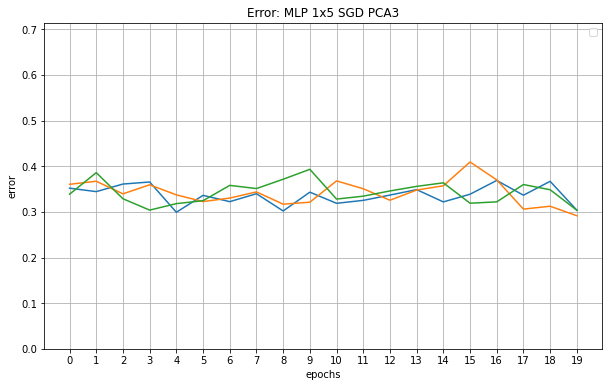

In [80]:
importlib.reload(ml)

ml.plotError(mlp15_sgd_ep20_pca3_error,best_config_cv,best_cv,'MLP 1x5 SGD PCA3',filename='mlp15_sgd_ep20_pca3_error',save=True)

### Selected features

## II) Model 2